In [1]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

import qiskit.tools.jupyter
%qiskit_version_table
#%qiskit_copyright

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from xbm import get_all_meas_circs_bits_coefs
from genc import get_all_meas_circs_bits_coefs_gc
from term_grouping import QWCCommutativity, FullCommutativity, genMeasureCircuit
from qwc import get_all_meas_circs_bits_coefs_qwc
from pauli import get_all_meas_circs_bits_coefs_pauli
import time
import random
import pickle
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from qwc import mat2operator
from utils import mat2H
from openfermion.measurements import group_into_tensor_product_basis_sets

In [3]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

colors = ['#FF99A0', '#C8C8CB', '#87E7B0', '#66CCFF']

In [4]:
def get_psi_A(nb_qubits, band_width, seed):
    np.random.seed(seed)
    psi_0 = QuantumCircuit(nb_qubits)
    psi_1 = QuantumCircuit(nb_qubits)

    for i in range(nb_qubits):
        psi_0.rx(np.random.random(),i)
        psi_0.ry(np.random.random(),i)
        psi_0.rz(np.random.random(),i)
        psi_1.rx(np.random.random(),i)
        psi_1.ry(np.random.random(),i)
        psi_1.rz(np.random.random(),i)

    rand_sign = np.array(random.choices([1,-1],k=(2**nb_qubits)**2)).reshape((2**nb_qubits,2**nb_qubits))
    mat_A = np.random.random(size=(2**nb_qubits,2**nb_qubits)).astype(np.complex128) * rand_sign
    rand_sign = np.array(random.choices([1,-1],k=(2**nb_qubits)**2)).reshape((2**nb_qubits,2**nb_qubits))
    mat_A += 1.j * np.random.random(size=(2**nb_qubits,2**nb_qubits)) * rand_sign
    mat_A *= 100.
    
    if band_width is not None:
        for i in range(2**nb_qubits):
            for j in range(2**nb_qubits):
                if np.abs(i-j)>band_width:
                    mat_A[i,j] = 0.
    
    return psi_0, psi_1, mat_A

In [5]:
def experiments(method, nb_qubits, band_width, is_psi_1, nb_trial, part='both', verbose=False):

    nb_circs_list = []
    elapsed_time_list = []
    
    for trial in tqdm(range(nb_trial)):

        if is_psi_1:
            psi_0, psi_1, mat_A = get_psi_A(nb_qubits, band_width, trial)
            if method=='QWC' or method=='QWC(BronKerbosch)' or method=='GC(BronKerbosch)':
                mat_A = np.kron(np.array([[0,2],[0,0]]),mat_A)
        else:
            psi_0, _, mat_A = get_psi_A(nb_qubits, band_width, trial)
            psi_1 = None


        if method=='QWC':
            H = mat2H(mat_A)
            operator = mat2operator(H=H)
        elif method=='QWC(BronKerbosch)' or method=='GC(BronKerbosch)':
            H = mat2H(mat_A)
        
        start = time.time()

        if method=='XBM':
            meas = get_all_meas_circs_bits_coefs(psi_0, psi_1, mat_A, part, return_circ=False)
        elif method=='Naive':
            meas = get_all_meas_circs_bits_coefs_pauli(psi_0, psi_1, mat_A, reduce=False)
        elif method=='QWC':
            meas = group_into_tensor_product_basis_sets(operator)
        elif method=='QWC(BronKerbosch)':
            if is_psi_1:
                meas, _ = genMeasureCircuit(H, nb_qubits+1, QWCCommutativity)
            else:
                meas, _ = genMeasureCircuit(H, nb_qubits, QWCCommutativity)
        elif method=='GC(BronKerbosch)':
            if is_psi_1:
                meas, _ = genMeasureCircuit(H, nb_qubits+1, FullCommutativity)
            else:
                meas, _ = genMeasureCircuit(H, nb_qubits, FullCommutativity)

        end = time.time()
        elapsed_time = end - start
        nb_circs = len(meas)
        
        if verbose:
            print('# measurements =', nb_circs)
            print('elapsed time', np.round(elapsed_time,3), '[s]\n')
        
        nb_circs_list += [nb_circs]
        elapsed_time_list += [elapsed_time]
        
    return nb_circs_list, elapsed_time_list

## $\big|\psi_0\big>=\big|\psi_1\big>$, $n=1,2,\cdots$, $k=3$

In [6]:
def take_mean(value, nb_trial):
    return np.array(value).reshape((len(value)//nb_trial, nb_trial)).mean(-1)

In [7]:
nb_trial = 10

print('===========================================')
print('                   XBM')
print('===========================================')
nb_circs_list_xbm = []
elapsed_time_list_xbm = []
for nb_qubits in range(1,15):
    foo, bar = experiments('XBM', nb_qubits, 3, False, nb_trial, part='both')
    nb_circs_list_xbm += foo
    elapsed_time_list_xbm += bar

print('===========================================')
print('                   XBM(half)')
print('===========================================')
nb_circs_list_xbm_half = []
elapsed_time_list_xbm_half = []
for nb_qubits in range(1,15):
    foo, bar = experiments('XBM', nb_qubits, 3, False, nb_trial, part='real')
    nb_circs_list_xbm_half += foo
    elapsed_time_list_xbm_half += bar
    
print('===========================================')
print('                   Naive')
print('===========================================')
nb_circs_list_naive = []
elapsed_time_list_naive = []
for nb_qubits in range(1,9):
    foo, bar = experiments('Naive', nb_qubits, 3, False, nb_trial)
    nb_circs_list_naive += foo
    elapsed_time_list_naive += bar
    
print('===========================================')
print('                   QWC')
print('===========================================')
nb_circs_list_qwc = []
elapsed_time_list_qwc = []
for nb_qubits in range(1,11):
    foo, bar = experiments('QWC', nb_qubits, 3, False, nb_trial)
    nb_circs_list_qwc += foo
    elapsed_time_list_qwc += bar
    
print('===========================================')
print('                   QWC(BronKerbosch)')
print('===========================================')
nb_circs_list_qwc_bk = []
elapsed_time_list_qwc_bk = []
for nb_qubits in range(1,9):
    foo, bar = experiments('QWC(BronKerbosch)', nb_qubits, 3, False, nb_trial)
    nb_circs_list_qwc_bk += foo
    elapsed_time_list_qwc_bk += bar
    
print('===========================================')
print('                   GC')
print('===========================================')
nb_circs_list_gc_bk = []
elapsed_time_list_gc_bk = []
for nb_qubits in range(1,7):
    foo, bar = experiments('GC(BronKerbosch)', nb_qubits, 3, False, nb_trial)
    nb_circs_list_gc_bk += foo
    elapsed_time_list_gc_bk += bar

                   XBM


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   XBM(half)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   Naive


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   QWC


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   QWC(BronKerbosch)


  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000113s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000180s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000090s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000123s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000088s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000089s
MEASURECIRCUIT: Generated graph for the Hamilt

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.001055s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.001061s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.001038s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000899s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000940s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.004009s
MEASURECIRCUIT: Generated graph for the 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 25 unique circuits
MEASURECIRCUIT: Elapsed time: 0.011538s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 25 unique circuits
MEASURECIRCUIT: Elapsed time: 0.011443s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 25 unique circuits
MEASURECIRCUIT: Elapsed time: 0.011568s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 25 unique circuits
MEASURECIRCUIT: Elapsed time: 0.011478s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 25 unique circuits
MEASURECIRCUIT: Elapsed time: 0.011565s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 25 unique circuits
MEASURECIRCUIT: Elapsed time: 0.011687s
MEASURECIRCUIT: Generated graph fo

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 57 unique circuits
MEASURECIRCUIT: Elapsed time: 0.111880s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 57 unique circuits
MEASURECIRCUIT: Elapsed time: 0.112221s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 57 unique circuits
MEASURECIRCUIT: Elapsed time: 0.113308s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 57 unique circuits
MEASURECIRCUIT: Elapsed time: 0.111560s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 57 unique circuits
MEASURECIRCUIT: Elapsed time: 0.111154s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 57 unique circuits
MEASURECIRCUIT: Elapsed time: 0.111817s
MEASURECIRCUIT: Generated gr

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.884779s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.904378s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.889503s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.896881s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.888662s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.897887s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 249 unique circuits
MEASURECIRCUIT: Elapsed time: 9.451411s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 249 unique circuits
MEASURECIRCUIT: Elapsed time: 9.482148s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 249 unique circuits
MEASURECIRCUIT: Elapsed time: 9.481130s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 249 unique circuits
MEASURECIRCUIT: Elapsed time: 9.608887s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 249 unique circuits
MEASURECIRCUIT: Elapsed time: 9.517374s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 249 unique circuits
MEASURECIRCUIT: Elapsed time: 9.591681s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 2431 nodes.
MEASURECIRCUIT: BronKerbosch found 505 unique circuits
MEASURECIRCUIT: Elapsed time: 63.310416s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 2431 nodes.
MEASURECIRCUIT: BronKerbosch found 505 unique circuits
MEASURECIRCUIT: Elapsed time: 63.855173s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 2431 nodes.
MEASURECIRCUIT: BronKerbosch found 505 unique circuits
MEASURECIRCUIT: Elapsed time: 63.741912s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 2431 nodes.
MEASURECIRCUIT: BronKerbosch found 505 unique circuits
MEASURECIRCUIT: Elapsed time: 63.710339s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 2431 nodes.
MEASURECIRCUIT: BronKerbosch found 505 unique circuits
MEASURECIRCUIT: Elapsed time: 63.687889s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 2431 nodes.
MEASURECIRCUIT: BronKerbosch found 505 unique circuits
MEASURECIRCUIT: Elapsed time: 63.841940s
MEASURECIR

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 5631 nodes.
MEASURECIRCUIT: BronKerbosch found 1017 unique circuits
MEASURECIRCUIT: Elapsed time: 3055.285665s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 5631 nodes.
MEASURECIRCUIT: BronKerbosch found 1017 unique circuits
MEASURECIRCUIT: Elapsed time: 3103.574069s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 5631 nodes.
MEASURECIRCUIT: BronKerbosch found 1017 unique circuits
MEASURECIRCUIT: Elapsed time: 3116.341913s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 5631 nodes.
MEASURECIRCUIT: BronKerbosch found 1017 unique circuits
MEASURECIRCUIT: Elapsed time: 3131.543141s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 5631 nodes.
MEASURECIRCUIT: BronKerbosch found 1017 unique circuits
MEASURECIRCUIT: Elapsed time: 3132.256913s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 5631 nodes.
MEASURECIRCUIT: BronKerbosch found 1017 unique circuits
MEASURECIRCUIT: Elapsed time: 3144.

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000114s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000096s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000147s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000094s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000129s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 3 nodes.
MEASURECIRCUIT: BronKerbosch found 3 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000095s
MEASURECIRCUIT: Generated graph for the Hamilt

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 5 unique circuits
MEASURECIRCUIT: Elapsed time: 0.002770s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 5 unique circuits
MEASURECIRCUIT: Elapsed time: 0.002618s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 5 unique circuits
MEASURECIRCUIT: Elapsed time: 0.001770s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 5 unique circuits
MEASURECIRCUIT: Elapsed time: 0.001803s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 5 unique circuits
MEASURECIRCUIT: Elapsed time: 0.001265s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 15 nodes.
MEASURECIRCUIT: BronKerbosch found 5 unique circuits
MEASURECIRCUIT: Elapsed time: 0.001239s
MEASURECIRCUIT: Generated graph for the 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.020288s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.020424s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.020588s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.020459s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.020378s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 55 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.020485s
MEASURECIRCUIT: Generated graph for the 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 15 unique circuits
MEASURECIRCUIT: Elapsed time: 0.497539s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 15 unique circuits
MEASURECIRCUIT: Elapsed time: 0.494658s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 15 unique circuits
MEASURECIRCUIT: Elapsed time: 0.499604s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 15 unique circuits
MEASURECIRCUIT: Elapsed time: 0.493229s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 15 unique circuits
MEASURECIRCUIT: Elapsed time: 0.494684s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 159 nodes.
MEASURECIRCUIT: BronKerbosch found 15 unique circuits
MEASURECIRCUIT: Elapsed time: 0.493855s
MEASURECIRCUIT: Generated gr

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 87.988717s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 88.782661s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 88.878003s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 89.314264s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 88.970696s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 89.108674s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 59000.394942s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 59260.817880s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 59516.937965s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 59603.323267s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 59839.697493s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 59637.013877

In [8]:
results = {
    'XBM'              :{'nb_circs':nb_circs_list_xbm,     'time':elapsed_time_list_xbm     },
    'XBM(half)'        :{'nb_circs':nb_circs_list_xbm_half,'time':elapsed_time_list_xbm_half},
    'Naive'            :{'nb_circs':nb_circs_list_naive,   'time':elapsed_time_list_naive   },
    'QWC'              :{'nb_circs':nb_circs_list_qwc,     'time':elapsed_time_list_qwc     },
    'QWC(BronKerbosch)':{'nb_circs':nb_circs_list_qwc_bk,  'time':elapsed_time_list_qwc_bk  },
    'GC(BronKerbosch)' :{'nb_circs':nb_circs_list_gc_bk,   'time':elapsed_time_list_gc_bk   },
}

with open('term_grouping_psi0psi0_keq3.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

In [9]:
with open('term_grouping_psi0psi0_keq3.pkl', 'rb') as f:
    results = pickle.load(f)
    
nb_circs_list_xbm      = take_mean(results['XBM']['nb_circs'], nb_trial)
nb_circs_list_xbm_half = take_mean(results['XBM(half)']['nb_circs'], nb_trial)
nb_circs_list_naive    = take_mean(results['Naive']['nb_circs'], nb_trial)
nb_circs_list_qwc      = take_mean(results['QWC']['nb_circs'], nb_trial)
nb_circs_list_gc_bk    = take_mean(results['GC(BronKerbosch)']['nb_circs'], nb_trial)

elapsed_time_list_xbm      = take_mean(results['XBM']['time'], nb_trial)
elapsed_time_list_xbm_half = take_mean(results['XBM(half)']['time'], nb_trial)
elapsed_time_list_naive    = take_mean(results['Naive']['time'], nb_trial)
elapsed_time_list_qwc      = take_mean(results['QWC']['time'], nb_trial)
elapsed_time_list_gc_bk    = take_mean(results['GC(BronKerbosch)']['time'], nb_trial)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


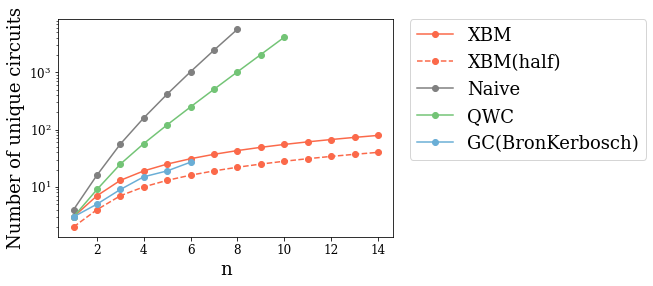

In [10]:
plt.plot(np.arange(1,len(nb_circs_list_xbm     )+1), nb_circs_list_xbm            , label='XBM'              , c=plt.get_cmap("Reds"  )(0.5), marker='o')
plt.plot(np.arange(1,len(nb_circs_list_xbm_half)+1), nb_circs_list_xbm_half       , label='XBM(half)'        , c=plt.get_cmap("Reds"  )(0.5), marker='o', linestyle='dashed')
plt.plot(np.arange(1,len(nb_circs_list_naive   )+1), nb_circs_list_naive          , label='Naive'            , c=plt.get_cmap("gray"  )(0.5), marker='o')
plt.plot(np.arange(1,len(nb_circs_list_qwc     )+1), nb_circs_list_qwc            , label='QWC'              , c=plt.get_cmap("Greens")(0.5), marker='o')
#plt.plot(np.arange(1,len(nb_circs_list_qwc_bk  )+1), nb_circs_list_qwc_bk         , label='QWC(BronKerbosch)', c=plt.get_cmap("Greens")(0.8), marker='o')
plt.plot(np.arange(1,len(nb_circs_list_gc_bk   )+1), nb_circs_list_gc_bk          , label='GC(BronKerbosch)' , c=plt.get_cmap("Blues" )(0.5), marker='o')
plt.xlabel('n')
plt.ylabel('Number of unique circuits')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('psiApsi-nbcircs-band3.pdf')
plt.savefig('psiApsi-nbcircs-band3.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


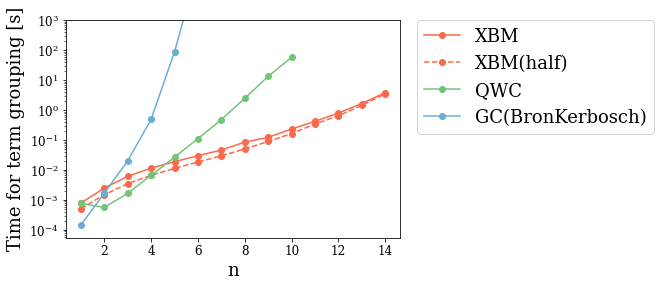

In [11]:
plt.plot(np.arange(1,len(elapsed_time_list_xbm     )+1), elapsed_time_list_xbm          , label='XBM'              , c=plt.get_cmap("Reds"  )(0.5), marker='o')
plt.plot(np.arange(1,len(elapsed_time_list_xbm_half)+1), elapsed_time_list_xbm_half     , label='XBM(half)'        , c=plt.get_cmap("Reds"  )(0.5), marker='o', linestyle='dashed')
plt.plot(np.arange(1,len(elapsed_time_list_qwc     )+1), elapsed_time_list_qwc          , label='QWC'              , c=plt.get_cmap("Greens")(0.5), marker='o')
#plt.plot(np.arange(1,len(elapsed_time_list_qwc_bk  )+1), elapsed_time_list_qwc_bk       , label='QWC(BronKerbosch)', c=plt.get_cmap("Greens")(0.8), marker='o')
plt.plot(np.arange(1,len(elapsed_time_list_gc_bk   )+1), elapsed_time_list_gc_bk        , label='GC(BronKerbosch)' , c=plt.get_cmap("Blues" )(0.5), marker='o')
plt.xlabel('n')
plt.ylabel('Time for term grouping [s]')
plt.yscale('log')
plt.ylim(None,1000)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('psiApsi-time-band3.pdf')
plt.savefig('psiApsi-time-band3.eps')

## $\big|\psi_0\big>=\big|\psi_1\big>$, $n=4$, $k=0,1,\cdots,2^n-1$

In [12]:
nb_qubits = 5
nb_trial = 10
    
print('===========================================')
print('                   XBM')
print('===========================================')
nb_circs_list_xbm = []
elapsed_time_list_xbm = []
for band_width in range(2**nb_qubits):
    foo, bar = experiments('XBM', nb_qubits, band_width, False, nb_trial, part='both')
    nb_circs_list_xbm += foo
    elapsed_time_list_xbm += bar

print('===========================================')
print('                   XBM(half)')
print('===========================================')
nb_circs_list_xbm_half = []
elapsed_time_list_xbm_half = []
for band_width in range(2**nb_qubits):
    foo, bar = experiments('XBM', nb_qubits, band_width, False, nb_trial, part='real')
    nb_circs_list_xbm_half += foo
    elapsed_time_list_xbm_half += bar
    
print('===========================================')
print('                   Naive')
print('===========================================')
nb_circs_list_naive = []
elapsed_time_list_naive = []
for band_width in range(2**nb_qubits):
    foo, bar = experiments('Naive', nb_qubits, band_width, False, nb_trial)
    nb_circs_list_naive += foo
    elapsed_time_list_naive += bar
    
print('===========================================')
print('                   QWC')
print('===========================================')
nb_circs_list_qwc = []
elapsed_time_list_qwc = []
for band_width in range(2**nb_qubits):
    foo, bar = experiments('QWC', nb_qubits, band_width, False, nb_trial)
    nb_circs_list_qwc += foo
    elapsed_time_list_qwc += bar
    
print('===========================================')
print('                   QWC(BronKerbosch)')
print('===========================================')
nb_circs_list_qwc_bk = []
elapsed_time_list_qwc_bk = []
for band_width in range(2**nb_qubits):
    foo, bar = experiments('QWC(BronKerbosch)', nb_qubits, band_width, False, nb_trial)
    nb_circs_list_qwc_bk += foo
    elapsed_time_list_qwc_bk += bar
    
print('===========================================')
print('                   GC(BronKerbosch)')
print('===========================================')
nb_circs_list_gc_bk = []
elapsed_time_list_gc_bk = []
for band_width in range(2**nb_qubits):
    foo, bar = experiments('GC(BronKerbosch)', nb_qubits, band_width, False, nb_trial)
    nb_circs_list_gc_bk += foo
    elapsed_time_list_gc_bk += bar

                   XBM


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   XBM(half)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   Naive


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   QWC


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   QWC(BronKerbosch)


  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009383s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009336s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009413s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009373s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009413s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009291s
MEASURECIRCUIT: Generated graph for the 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 63 unique circuits
MEASURECIRCUIT: Elapsed time: 0.183780s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 63 unique circuits
MEASURECIRCUIT: Elapsed time: 0.184723s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 63 unique circuits
MEASURECIRCUIT: Elapsed time: 0.183919s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 63 unique circuits
MEASURECIRCUIT: Elapsed time: 0.183424s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 63 unique circuits
MEASURECIRCUIT: Elapsed time: 0.182611s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 63 unique circuits
MEASURECIRCUIT: Elapsed time: 0.182540s
MEASURECIRCUIT: Generated gr

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 93 unique circuits
MEASURECIRCUIT: Elapsed time: 0.525671s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 93 unique circuits
MEASURECIRCUIT: Elapsed time: 0.526133s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 93 unique circuits
MEASURECIRCUIT: Elapsed time: 0.530495s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 93 unique circuits
MEASURECIRCUIT: Elapsed time: 0.522762s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 93 unique circuits
MEASURECIRCUIT: Elapsed time: 0.521135s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 93 unique circuits
MEASURECIRCUIT: Elapsed time: 0.523247s
MEASURECIRCUIT: Generated gr

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.827743s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.830731s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.846207s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.831490s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.834423s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 121 unique circuits
MEASURECIRCUIT: Elapsed time: 0.837536s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 135 unique circuits
MEASURECIRCUIT: Elapsed time: 1.448083s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 135 unique circuits
MEASURECIRCUIT: Elapsed time: 1.447982s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 135 unique circuits
MEASURECIRCUIT: Elapsed time: 1.467603s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 135 unique circuits
MEASURECIRCUIT: Elapsed time: 1.460864s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 135 unique circuits
MEASURECIRCUIT: Elapsed time: 1.455403s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 135 unique circuits
MEASURECIRCUIT: Elapsed time: 1.463517s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 159 unique circuits
MEASURECIRCUIT: Elapsed time: 1.783940s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 159 unique circuits
MEASURECIRCUIT: Elapsed time: 1.804204s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 159 unique circuits
MEASURECIRCUIT: Elapsed time: 1.806516s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 159 unique circuits
MEASURECIRCUIT: Elapsed time: 1.807059s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 159 unique circuits
MEASURECIRCUIT: Elapsed time: 1.820255s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 159 unique circuits
MEASURECIRCUIT: Elapsed time: 1.812215s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 171 unique circuits
MEASURECIRCUIT: Elapsed time: 2.182464s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 171 unique circuits
MEASURECIRCUIT: Elapsed time: 2.205227s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 171 unique circuits
MEASURECIRCUIT: Elapsed time: 2.199477s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 171 unique circuits
MEASURECIRCUIT: Elapsed time: 2.208213s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 171 unique circuits
MEASURECIRCUIT: Elapsed time: 2.199289s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 171 unique circuits
MEASURECIRCUIT: Elapsed time: 2.197964s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 183 unique circuits
MEASURECIRCUIT: Elapsed time: 2.732366s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 183 unique circuits
MEASURECIRCUIT: Elapsed time: 2.749687s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 183 unique circuits
MEASURECIRCUIT: Elapsed time: 2.769134s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 183 unique circuits
MEASURECIRCUIT: Elapsed time: 2.749084s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 183 unique circuits
MEASURECIRCUIT: Elapsed time: 2.773803s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 183 unique circuits
MEASURECIRCUIT: Elapsed time: 2.779349s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 189 unique circuits
MEASURECIRCUIT: Elapsed time: 3.721080s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 189 unique circuits
MEASURECIRCUIT: Elapsed time: 3.717143s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 189 unique circuits
MEASURECIRCUIT: Elapsed time: 3.730974s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 189 unique circuits
MEASURECIRCUIT: Elapsed time: 3.748310s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 189 unique circuits
MEASURECIRCUIT: Elapsed time: 3.721413s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 189 unique circuits
MEASURECIRCUIT: Elapsed time: 3.750639s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 205 unique circuits
MEASURECIRCUIT: Elapsed time: 3.983321s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 205 unique circuits
MEASURECIRCUIT: Elapsed time: 4.003474s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 205 unique circuits
MEASURECIRCUIT: Elapsed time: 4.006783s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 205 unique circuits
MEASURECIRCUIT: Elapsed time: 4.011191s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 205 unique circuits
MEASURECIRCUIT: Elapsed time: 3.999552s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 205 unique circuits
MEASURECIRCUIT: Elapsed time: 4.008646s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 213 unique circuits
MEASURECIRCUIT: Elapsed time: 4.252936s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 213 unique circuits
MEASURECIRCUIT: Elapsed time: 4.224629s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 213 unique circuits
MEASURECIRCUIT: Elapsed time: 4.254723s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 213 unique circuits
MEASURECIRCUIT: Elapsed time: 4.261130s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 213 unique circuits
MEASURECIRCUIT: Elapsed time: 4.258859s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 213 unique circuits
MEASURECIRCUIT: Elapsed time: 4.230457s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 221 unique circuits
MEASURECIRCUIT: Elapsed time: 4.587296s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 221 unique circuits
MEASURECIRCUIT: Elapsed time: 4.581055s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 221 unique circuits
MEASURECIRCUIT: Elapsed time: 4.610780s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 221 unique circuits
MEASURECIRCUIT: Elapsed time: 4.603381s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 221 unique circuits
MEASURECIRCUIT: Elapsed time: 4.562691s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 221 unique circuits
MEASURECIRCUIT: Elapsed time: 4.566478s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 225 unique circuits
MEASURECIRCUIT: Elapsed time: 4.859606s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 225 unique circuits
MEASURECIRCUIT: Elapsed time: 4.894549s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 225 unique circuits
MEASURECIRCUIT: Elapsed time: 4.869468s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 225 unique circuits
MEASURECIRCUIT: Elapsed time: 4.863593s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 225 unique circuits
MEASURECIRCUIT: Elapsed time: 4.912904s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 225 unique circuits
MEASURECIRCUIT: Elapsed time: 4.907059s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 233 unique circuits
MEASURECIRCUIT: Elapsed time: 5.267186s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 233 unique circuits
MEASURECIRCUIT: Elapsed time: 5.300093s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 233 unique circuits
MEASURECIRCUIT: Elapsed time: 5.264514s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 233 unique circuits
MEASURECIRCUIT: Elapsed time: 5.284477s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 233 unique circuits
MEASURECIRCUIT: Elapsed time: 5.346797s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 233 unique circuits
MEASURECIRCUIT: Elapsed time: 5.286422s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 237 unique circuits
MEASURECIRCUIT: Elapsed time: 5.609301s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 237 unique circuits
MEASURECIRCUIT: Elapsed time: 5.592276s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 237 unique circuits
MEASURECIRCUIT: Elapsed time: 5.579890s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 237 unique circuits
MEASURECIRCUIT: Elapsed time: 5.584309s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 237 unique circuits
MEASURECIRCUIT: Elapsed time: 5.586454s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 237 unique circuits
MEASURECIRCUIT: Elapsed time: 5.610337s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 241 unique circuits
MEASURECIRCUIT: Elapsed time: 6.209341s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 241 unique circuits
MEASURECIRCUIT: Elapsed time: 6.234271s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 241 unique circuits
MEASURECIRCUIT: Elapsed time: 6.242760s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 241 unique circuits
MEASURECIRCUIT: Elapsed time: 6.246489s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 241 unique circuits
MEASURECIRCUIT: Elapsed time: 6.258471s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 241 unique circuits
MEASURECIRCUIT: Elapsed time: 6.217791s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.706810s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.775957s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.790247s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.786407s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.804252s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.779522s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.748126s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.728549s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.781189s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.719748s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.804902s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.757150s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.718117s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.786095s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.726302s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.742554s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.771203s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.690696s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.696489s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.754548s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.809282s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.797166s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.760864s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.809485s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.728959s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.766863s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.790856s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.750106s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.785142s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.799613s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.755004s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.731892s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.755222s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.758563s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.733265s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.802170s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.729322s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.774488s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.769121s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.743588s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.784260s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.760731s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.736395s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.795437s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.760032s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.754258s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.728001s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.718376s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.694085s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.733855s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.781759s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.725764s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.761386s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.744251s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.777052s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.724187s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.720373s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.730862s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.710504s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.751084s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.759491s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.756733s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.766224s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.733209s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.772453s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.691368s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.733660s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.701080s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.721253s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.727821s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.714261s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.795710s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.727464s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.766493s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.737581s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.750002s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.764097s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.757752s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.744374s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.794887s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.739839s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.723673s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.772458s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.711914s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.828144s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.769586s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.788262s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.742087s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.734185s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.719420s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.751843s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.770735s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.782341s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.829807s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.757035s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 243 unique circuits
MEASURECIRCUIT: Elapsed time: 6.733407s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009477s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009424s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009435s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009489s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009479s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 1 unique circuits
MEASURECIRCUIT: Elapsed time: 0.009387s
MEASURECIRCUIT: Generated graph for the 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 11 unique circuits
MEASURECIRCUIT: Elapsed time: 2.208211s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 11 unique circuits
MEASURECIRCUIT: Elapsed time: 2.220170s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 11 unique circuits
MEASURECIRCUIT: Elapsed time: 2.219535s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 11 unique circuits
MEASURECIRCUIT: Elapsed time: 2.219017s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 11 unique circuits
MEASURECIRCUIT: Elapsed time: 2.225140s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 191 nodes.
MEASURECIRCUIT: BronKerbosch found 11 unique circuits
MEASURECIRCUIT: Elapsed time: 2.213376s
MEASURECIRCUIT: Generated gr

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 24.536241s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 24.574852s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 24.646091s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 24.641281s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 24.710016s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 24.591904s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 81.831977s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 82.152271s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 82.347732s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 82.236671s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 82.253538s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 415 nodes.
MEASURECIRCUIT: BronKerbosch found 19 unique circuits
MEASURECIRCUIT: Elapsed time: 82.382042s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 213.057570s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 214.546793s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 214.383448s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 214.068452s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 214.536108s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 511 nodes.
MEASURECIRCUIT: BronKerbosch found 27 unique circuits
MEASURECIRCUIT: Elapsed time: 215.680028s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 33 unique circuits
MEASURECIRCUIT: Elapsed time: 386.926690s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 33 unique circuits
MEASURECIRCUIT: Elapsed time: 386.428485s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 33 unique circuits
MEASURECIRCUIT: Elapsed time: 387.354997s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 33 unique circuits
MEASURECIRCUIT: Elapsed time: 386.739479s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 33 unique circuits
MEASURECIRCUIT: Elapsed time: 387.732980s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 575 nodes.
MEASURECIRCUIT: BronKerbosch found 33 unique circuits
MEASURECIRCUIT: Elapsed time: 387.326350s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 34 unique circuits
MEASURECIRCUIT: Elapsed time: 612.545747s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 34 unique circuits
MEASURECIRCUIT: Elapsed time: 612.124559s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 34 unique circuits
MEASURECIRCUIT: Elapsed time: 612.943178s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 34 unique circuits
MEASURECIRCUIT: Elapsed time: 613.864344s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 34 unique circuits
MEASURECIRCUIT: Elapsed time: 612.886155s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 639 nodes.
MEASURECIRCUIT: BronKerbosch found 34 unique circuits
MEASURECIRCUIT: Elapsed time: 612.892682s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 36 unique circuits
MEASURECIRCUIT: Elapsed time: 966.920621s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 36 unique circuits
MEASURECIRCUIT: Elapsed time: 969.235572s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 36 unique circuits
MEASURECIRCUIT: Elapsed time: 970.625822s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 36 unique circuits
MEASURECIRCUIT: Elapsed time: 969.808873s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 36 unique circuits
MEASURECIRCUIT: Elapsed time: 970.980016s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 703 nodes.
MEASURECIRCUIT: BronKerbosch found 36 unique circuits
MEASURECIRCUIT: Elapsed time: 970.312341s
MEASURECIRCUIT: 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 38 unique circuits
MEASURECIRCUIT: Elapsed time: 1357.985744s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 38 unique circuits
MEASURECIRCUIT: Elapsed time: 1327.775517s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 38 unique circuits
MEASURECIRCUIT: Elapsed time: 1327.734440s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 38 unique circuits
MEASURECIRCUIT: Elapsed time: 1327.872778s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 38 unique circuits
MEASURECIRCUIT: Elapsed time: 1328.432413s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 767 nodes.
MEASURECIRCUIT: BronKerbosch found 38 unique circuits
MEASURECIRCUIT: Elapsed time: 1330.977843s
MEASURECIR

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1582.082406s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1584.637895s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1593.722864s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1585.832444s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1615.645309s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 799 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1596.112900s
MEASURECIR

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1785.255199s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1789.761399s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1791.175195s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1818.218460s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1803.451546s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 45 unique circuits
MEASURECIRCUIT: Elapsed time: 1792.266915s
MEASURECIR

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2103.601544s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2106.447301s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2110.562693s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2114.425531s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2116.802763s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 863 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2112.717566s
MEASURECIR

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 46 unique circuits
MEASURECIRCUIT: Elapsed time: 2342.575323s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 46 unique circuits
MEASURECIRCUIT: Elapsed time: 2346.233792s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 46 unique circuits
MEASURECIRCUIT: Elapsed time: 2360.350114s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 46 unique circuits
MEASURECIRCUIT: Elapsed time: 2374.598941s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 46 unique circuits
MEASURECIRCUIT: Elapsed time: 2357.500687s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 895 nodes.
MEASURECIRCUIT: BronKerbosch found 46 unique circuits
MEASURECIRCUIT: Elapsed time: 2350.874362s
MEASURECIR

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2680.515110s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2704.225837s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2704.598875s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2707.572155s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2719.146836s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 927 nodes.
MEASURECIRCUIT: BronKerbosch found 47 unique circuits
MEASURECIRCUIT: Elapsed time: 2701.035708s
MEASURECIR

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3085.435642s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3105.863483s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3113.931072s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3112.117891s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3110.767845s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 959 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3114.272518s
MEASURECIR

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3505.402869s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3542.112309s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3537.769135s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3537.486943s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3538.385694s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 991 nodes.
MEASURECIRCUIT: BronKerbosch found 49 unique circuits
MEASURECIRCUIT: Elapsed time: 3536.742937s
MEASURECIR

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3668.238333s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3687.134115s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3729.343012s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3696.263405s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3709.897976s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3701.977645s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3651.070406s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3683.231619s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3695.007247s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3697.819037s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3695.018794s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3693.261370s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3661.753616s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3693.489425s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3709.725507s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3711.987636s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3721.718986s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3710.184648s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3662.878220s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3689.130556s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3692.613230s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3697.556638s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3693.645464s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3707.572396s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3672.547421s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3694.201075s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3700.797871s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3708.019129s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3749.540921s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3703.149840s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3662.754286s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3694.206527s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3699.884143s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3712.690676s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3705.590635s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3703.544850s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3677.085885s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3697.469217s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3704.568242s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3706.358787s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3720.890190s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3702.406670s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3668.013144s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3816.786933s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3715.735768s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3709.276623s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3698.393031s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3694.999784s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3655.168494s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3701.253546s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3696.560476s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3731.586186s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3700.051721s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3698.171095s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3670.659992s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3688.264946s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3698.154120s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3701.083431s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3702.886590s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3694.193629s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3656.258589s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3680.796130s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3689.431267s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3685.398704s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3691.606657s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3683.474519s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3663.649383s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3725.644958s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3702.583897s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3703.524778s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3726.960773s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3697.050380s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3663.105900s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3688.181363s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3696.645180s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3697.246763s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3703.522435s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3692.114487s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3661.141065s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3692.863008s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3698.068877s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3706.967704s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3699.574148s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3703.303998s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3810.355484s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3707.591391s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3699.173790s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3699.358001s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3710.103765s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3696.415807s
MEAS

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3650.786043s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3694.388376s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3704.025224s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3715.428694s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3706.393128s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 1023 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 3709.803975s
MEAS

In [13]:
results = {
    'XBM'              :{'nb_circs':nb_circs_list_xbm,     'time':elapsed_time_list_xbm     },
    'XBM(half)'        :{'nb_circs':nb_circs_list_xbm_half,'time':elapsed_time_list_xbm_half},
    'Naive'            :{'nb_circs':nb_circs_list_naive,   'time':elapsed_time_list_naive   },
    'QWC'              :{'nb_circs':nb_circs_list_qwc,     'time':elapsed_time_list_qwc     },
    'QWC(BronKerbosch)':{'nb_circs':nb_circs_list_qwc_bk,  'time':elapsed_time_list_qwc_bk  },
    'GC(BronKerbosch)' :{'nb_circs':nb_circs_list_gc_bk,   'time':elapsed_time_list_gc_bk   },
}

with open('term_grouping_psi0psi0_neq5.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

In [14]:
with open('term_grouping_psi0psi0_neq5.pkl', 'rb') as f:
    results = pickle.load(f)
    
nb_circs_list_xbm      = take_mean(results['XBM']['nb_circs'], nb_trial)
nb_circs_list_xbm_half = take_mean(results['XBM(half)']['nb_circs'], nb_trial)
nb_circs_list_naive    = take_mean(results['Naive']['nb_circs'], nb_trial)
nb_circs_list_qwc      = take_mean(results['QWC']['nb_circs'], nb_trial)
nb_circs_list_gc_bk    = take_mean(results['GC(BronKerbosch)']['nb_circs'], nb_trial)

elapsed_time_list_xbm      = take_mean(results['XBM']['time'], nb_trial)
elapsed_time_list_xbm_half = take_mean(results['XBM(half)']['time'], nb_trial)
elapsed_time_list_naive    = take_mean(results['Naive']['time'], nb_trial)
elapsed_time_list_qwc      = take_mean(results['QWC']['time'], nb_trial)
elapsed_time_list_gc_bk    = take_mean(results['GC(BronKerbosch)']['time'], nb_trial)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


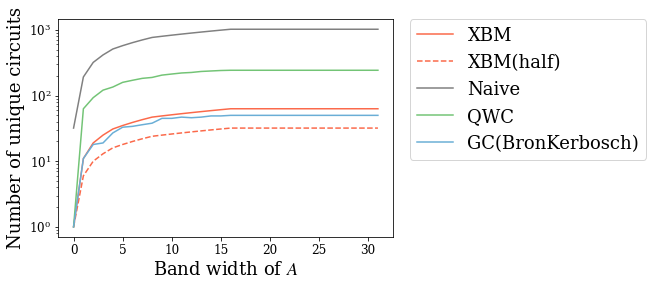

In [15]:
plt.plot(np.arange(len(nb_circs_list_xbm     )), nb_circs_list_xbm            , label='XBM'              , c=plt.get_cmap("Reds"  )(0.5))
plt.plot(np.arange(len(nb_circs_list_xbm_half)), nb_circs_list_xbm_half       , label='XBM(half)'        , c=plt.get_cmap("Reds"  )(0.5), linestyle='dashed')
plt.plot(np.arange(len(nb_circs_list_naive   )), nb_circs_list_naive          , label='Naive'            , c=plt.get_cmap("gray"  )(0.5))
plt.plot(np.arange(len(nb_circs_list_qwc     )), nb_circs_list_qwc            , label='QWC'              , c=plt.get_cmap("Greens")(0.5))
#plt.plot(np.arange(len(nb_circs_list_qwc_bk  )), nb_circs_list_qwc_bk         , label='QWC(BronKerbosch)', c=plt.get_cmap("Greens")(0.8))
plt.plot(np.arange(len(nb_circs_list_gc_bk   )), nb_circs_list_gc_bk          , label='GC(BronKerbosch)' , c=plt.get_cmap("Blues" )(0.5))
plt.xlabel('Band width of $A$')
plt.ylabel('Number of unique circuits')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('psiApsi-nbcircs-5qubits.pdf')
plt.savefig('psiApsi-nbcircs-5qubits.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


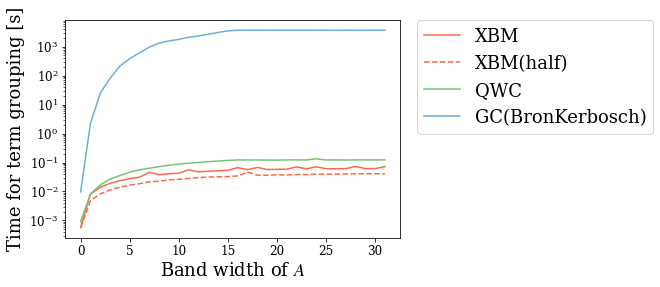

In [16]:
plt.plot(np.arange(len(elapsed_time_list_xbm     )), elapsed_time_list_xbm          , label='XBM'              , c=plt.get_cmap("Reds"  )(0.5))
plt.plot(np.arange(len(elapsed_time_list_xbm_half)), elapsed_time_list_xbm_half     , label='XBM(half)'        , c=plt.get_cmap("Reds"  )(0.5), linestyle='dashed')
plt.plot(np.arange(len(elapsed_time_list_qwc     )), elapsed_time_list_qwc          , label='QWC'              , c=plt.get_cmap("Greens")(0.5))
#plt.plot(np.arange(len(elapsed_time_list_qwc_bk  )), elapsed_time_list_qwc_bk       , label='QWC(BronKerbosch)', c=plt.get_cmap("Greens")(0.8))
plt.plot(np.arange(len(elapsed_time_list_gc_bk   )), elapsed_time_list_gc_bk        , label='GC(BronKerbosch)' , c=plt.get_cmap("Blues" )(0.5))
plt.xlabel('Band width of $A$')
plt.ylabel('Time for term grouping [s]')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('psiApsi-time-5qubits.pdf')
plt.savefig('psiApsi-time-5qubits.eps')

## $\big|\psi_0\big>\neq\big|\psi_1\big>$, $n=1,2,\cdots$, $k=3$

In [17]:
nb_trial = 10

print('===========================================')
print('                   XBM')
print('===========================================')
nb_circs_list_xbm = []
elapsed_time_list_xbm = []
for nb_qubits in range(1,14):
    foo, bar = experiments('XBM', nb_qubits, 3, True, nb_trial, part='both')
    nb_circs_list_xbm += foo
    elapsed_time_list_xbm += bar

print('===========================================')
print('                   XBM(half)')
print('===========================================')
nb_circs_list_xbm_half = []
elapsed_time_list_xbm_half = []
for nb_qubits in range(1,14):
    foo, bar = experiments('XBM', nb_qubits, 3, True, nb_trial, part='real')
    nb_circs_list_xbm_half += foo
    elapsed_time_list_xbm_half += bar
    
print('===========================================')
print('                   Naive')
print('===========================================')
nb_circs_list_naive = []
elapsed_time_list_naive = []
for nb_qubits in range(1,8):
    foo, bar = experiments('Naive', nb_qubits, 3, True, nb_trial)
    nb_circs_list_naive += foo
    elapsed_time_list_naive += bar
    
print('===========================================')
print('                   QWC')
print('===========================================')
nb_circs_list_qwc = []
elapsed_time_list_qwc = []
for nb_qubits in range(1,10):
    foo, bar = experiments('QWC', nb_qubits, 3, True, nb_trial)
    nb_circs_list_qwc += foo
    elapsed_time_list_qwc += bar
    
print('===========================================')
print('                   QWC(BronKerbosch)')
print('===========================================')
nb_circs_list_qwc_bk = []
elapsed_time_list_qwc_bk = []
for nb_qubits in range(1,8):
    foo, bar = experiments('QWC(BronKerbosch)', nb_qubits, 3, True, nb_trial)
    nb_circs_list_qwc_bk += foo
    elapsed_time_list_qwc_bk += bar
    
print('===========================================')
print('                   GC(BronKerbosch)')
print('===========================================')
nb_circs_list_gc_bk = []
elapsed_time_list_gc_bk = []
for nb_qubits in range(1,6):
    foo, bar = experiments('GC(BronKerbosch)', nb_qubits, 3, True, nb_trial)
    nb_circs_list_gc_bk += foo
    elapsed_time_list_gc_bk += bar

                   XBM


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   XBM(half)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   Naive


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   QWC


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

                   QWC(BronKerbosch)


  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 6 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000366s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 6 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000257s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 6 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000251s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 6 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000254s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 6 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000251s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 6 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000255s
MEASURECIRCUIT: Generated graph for the Hamilt

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.003413s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.003414s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.003390s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.003466s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.003386s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.003429s
MEASURECIRCUIT: Generated graph fo

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 0.043144s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 0.043195s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 0.043117s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 0.043747s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 0.043241s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 50 unique circuits
MEASURECIRCUIT: Elapsed time: 0.043909s
MEASURECIRCUIT: Generated gr

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 114 unique circuits
MEASURECIRCUIT: Elapsed time: 0.377471s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 114 unique circuits
MEASURECIRCUIT: Elapsed time: 0.382811s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 114 unique circuits
MEASURECIRCUIT: Elapsed time: 0.383869s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 114 unique circuits
MEASURECIRCUIT: Elapsed time: 0.385110s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 114 unique circuits
MEASURECIRCUIT: Elapsed time: 0.383191s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 114 unique circuits
MEASURECIRCUIT: Elapsed time: 0.382318s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 242 unique circuits
MEASURECIRCUIT: Elapsed time: 2.815113s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 242 unique circuits
MEASURECIRCUIT: Elapsed time: 2.844048s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 242 unique circuits
MEASURECIRCUIT: Elapsed time: 2.817819s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 242 unique circuits
MEASURECIRCUIT: Elapsed time: 2.811334s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 242 unique circuits
MEASURECIRCUIT: Elapsed time: 2.838769s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 242 unique circuits
MEASURECIRCUIT: Elapsed time: 2.824542s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 2047 nodes.
MEASURECIRCUIT: BronKerbosch found 498 unique circuits
MEASURECIRCUIT: Elapsed time: 22.907509s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 2047 nodes.
MEASURECIRCUIT: BronKerbosch found 498 unique circuits
MEASURECIRCUIT: Elapsed time: 23.169879s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 2047 nodes.
MEASURECIRCUIT: BronKerbosch found 498 unique circuits
MEASURECIRCUIT: Elapsed time: 23.154054s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 2047 nodes.
MEASURECIRCUIT: BronKerbosch found 498 unique circuits
MEASURECIRCUIT: Elapsed time: 23.074098s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 2047 nodes.
MEASURECIRCUIT: BronKerbosch found 498 unique circuits
MEASURECIRCUIT: Elapsed time: 23.025191s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 2047 nodes.
MEASURECIRCUIT: BronKerbosch found 498 unique circuits
MEASURECIRCUIT: Elapsed time: 23.193504s
MEASURECIR

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 4863 nodes.
MEASURECIRCUIT: BronKerbosch found 1010 unique circuits
MEASURECIRCUIT: Elapsed time: 324.611841s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 4863 nodes.
MEASURECIRCUIT: BronKerbosch found 1010 unique circuits
MEASURECIRCUIT: Elapsed time: 326.880928s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 4863 nodes.
MEASURECIRCUIT: BronKerbosch found 1010 unique circuits
MEASURECIRCUIT: Elapsed time: 328.086576s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 4863 nodes.
MEASURECIRCUIT: BronKerbosch found 1010 unique circuits
MEASURECIRCUIT: Elapsed time: 326.873358s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 4863 nodes.
MEASURECIRCUIT: BronKerbosch found 1010 unique circuits
MEASURECIRCUIT: Elapsed time: 327.779985s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 4863 nodes.
MEASURECIRCUIT: BronKerbosch found 1010 unique circuits
MEASURECIRCUIT: Elapsed time: 328.199768

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 4 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000439s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 4 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000329s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 4 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000330s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 4 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000330s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 4 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000328s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 7 nodes.
MEASURECIRCUIT: BronKerbosch found 4 unique circuits
MEASURECIRCUIT: Elapsed time: 0.000330s
MEASURECIRCUIT: Generated graph for the Hamilt

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.006734s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.006453s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.006472s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.006454s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.006420s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 31 nodes.
MEASURECIRCUIT: BronKerbosch found 9 unique circuits
MEASURECIRCUIT: Elapsed time: 0.010595s
MEASURECIRCUIT: Generated graph for the 

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.148851s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.151043s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.149752s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.149189s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.148748s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 111 nodes.
MEASURECIRCUIT: BronKerbosch found 18 unique circuits
MEASURECIRCUIT: Elapsed time: 0.148813s
MEASURECIRCUIT: Generated gr

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 28 unique circuits
MEASURECIRCUIT: Elapsed time: 12.356334s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 28 unique circuits
MEASURECIRCUIT: Elapsed time: 12.504535s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 28 unique circuits
MEASURECIRCUIT: Elapsed time: 12.464870s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 28 unique circuits
MEASURECIRCUIT: Elapsed time: 12.467671s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 28 unique circuits
MEASURECIRCUIT: Elapsed time: 12.425226s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 319 nodes.
MEASURECIRCUIT: BronKerbosch found 28 unique circuits
MEASURECIRCUIT: Elapsed time: 12.454007s
MEASURECIRCUIT: Genera

  0%|          | 0/10 [00:00<?, ?it/s]

MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 35 unique circuits
MEASURECIRCUIT: Elapsed time: 4832.268249s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 35 unique circuits
MEASURECIRCUIT: Elapsed time: 4865.083784s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 35 unique circuits
MEASURECIRCUIT: Elapsed time: 4893.980405s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 35 unique circuits
MEASURECIRCUIT: Elapsed time: 4874.073412s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 35 unique circuits
MEASURECIRCUIT: Elapsed time: 4886.648424s
MEASURECIRCUIT: Generated graph for the Hamiltonian with 831 nodes.
MEASURECIRCUIT: BronKerbosch found 35 unique circuits
MEASURECIRCUIT: Elapsed time: 4879.766265s
MEASURECIR

In [18]:
results = {
    'XBM'              :{'nb_circs':nb_circs_list_xbm,     'time':elapsed_time_list_xbm},
    'XBM(half)'        :{'nb_circs':nb_circs_list_xbm_half,'time':elapsed_time_list_xbm_half},
    'Naive'            :{'nb_circs':nb_circs_list_naive,   'time':elapsed_time_list_naive},
    'QWC'              :{'nb_circs':nb_circs_list_qwc,     'time':elapsed_time_list_qwc},
    'QWC(BronKerbosch)':{'nb_circs':nb_circs_list_qwc_bk,  'time':elapsed_time_list_qwc_bk},
    'GC(BronKerbosch)' :{'nb_circs':nb_circs_list_gc_bk,   'time':elapsed_time_list_gc_bk},
}

with open('term_grouping_psi0psi1_keq3.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

In [19]:
with open('term_grouping_psi0psi1_keq3.pkl', 'rb') as f:
    results = pickle.load(f)
    
nb_circs_list_xbm      = take_mean(results['XBM']['nb_circs'], nb_trial)
nb_circs_list_xbm_half = take_mean(results['XBM(half)']['nb_circs'], nb_trial)
nb_circs_list_naive    = take_mean(results['Naive']['nb_circs'], nb_trial)
nb_circs_list_qwc      = take_mean(results['QWC']['nb_circs'], nb_trial)
nb_circs_list_gc_bk    = take_mean(results['GC(BronKerbosch)']['nb_circs'], nb_trial)

elapsed_time_list_xbm      = take_mean(results['XBM']['time'], nb_trial)
elapsed_time_list_xbm_half = take_mean(results['XBM(half)']['time'], nb_trial)
elapsed_time_list_naive    = take_mean(results['Naive']['time'], nb_trial)
elapsed_time_list_qwc      = take_mean(results['QWC']['time'], nb_trial)
elapsed_time_list_gc_bk    = take_mean(results['GC(BronKerbosch)']['time'], nb_trial)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


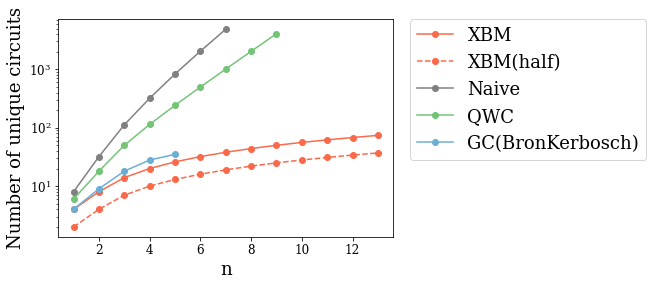

In [20]:
plt.plot(np.arange(1,len(nb_circs_list_xbm     )+1), nb_circs_list_xbm            , label='XBM'              , c=plt.get_cmap("Reds"  )(0.5), marker='o')
plt.plot(np.arange(1,len(nb_circs_list_xbm_half)+1), nb_circs_list_xbm_half       , label='XBM(half)'        , c=plt.get_cmap("Reds"  )(0.5), marker='o', linestyle='dashed')
plt.plot(np.arange(1,len(nb_circs_list_naive   )+1), nb_circs_list_naive          , label='Naive'            , c=plt.get_cmap("gray"  )(0.5), marker='o')
plt.plot(np.arange(1,len(nb_circs_list_qwc     )+1), nb_circs_list_qwc            , label='QWC'              , c=plt.get_cmap("Greens")(0.5), marker='o')
#plt.plot(np.arange(1,len(nb_circs_list_qwc_bk  )+1), nb_circs_list_qwc_bk         , label='QWC(BronKerbosch)', c=plt.get_cmap("Greens")(0.8), marker='o')
plt.plot(np.arange(1,len(nb_circs_list_gc_bk   )+1), nb_circs_list_gc_bk          , label='GC(BronKerbosch)' , c=plt.get_cmap("Blues" )(0.5), marker='o')
plt.xlabel('n')
plt.ylabel('Number of unique circuits')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('psi0Apsi1-nbcircs-band3.pdf')
plt.savefig('psi0Apsi1-nbcircs-band3.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


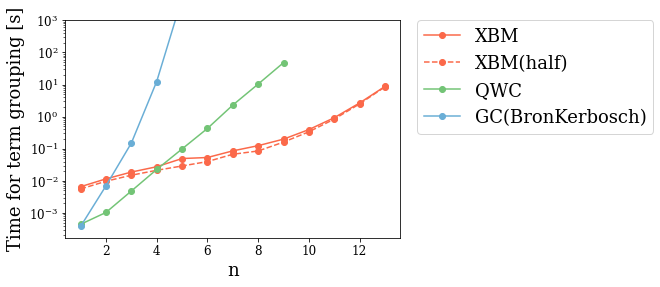

In [21]:
plt.plot(np.arange(1,len(elapsed_time_list_xbm     )+1), elapsed_time_list_xbm          , label='XBM'              , c=plt.get_cmap("Reds"  )(0.5), marker='o')
plt.plot(np.arange(1,len(elapsed_time_list_xbm_half)+1), elapsed_time_list_xbm_half     , label='XBM(half)'        , c=plt.get_cmap("Reds"  )(0.5), marker='o', linestyle='dashed')
plt.plot(np.arange(1,len(elapsed_time_list_qwc     )+1), elapsed_time_list_qwc          , label='QWC'              , c=plt.get_cmap("Greens")(0.5), marker='o')
#plt.plot(np.arange(1,len(elapsed_time_list_qwc_bk  )+1), elapsed_time_list_qwc_bk       , label='QWC(BronKerbosch)', c=plt.get_cmap("Greens")(0.8), marker='o')
plt.plot(np.arange(1,len(elapsed_time_list_gc_bk   )+1), elapsed_time_list_gc_bk        , label='GC(BronKerbosch)' , c=plt.get_cmap("Blues" )(0.5), marker='o')

n = np.arange(1,len(elapsed_time_list_xbm     )+1)
#plt.plot(n, 4.4**n/50000, label='4.5^n', c=plt.get_cmap("gray"  )(0.5))
#plt.plot(n, 2.2**n/2000, label='2.2^n', c=plt.get_cmap("gray"  )(0.5))
#plt.plot(n, 2**n/1000, label='2^n', c=plt.get_cmap("gray"  )(0.5))

plt.xlabel('n')
plt.ylabel('Time for term grouping [s]')
plt.yscale('log')
plt.ylim(None,1000)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('psi0Apsi1-time-band3.pdf')
plt.savefig('psi0Apsi1-time-band3.eps')

# random-$A$

In [22]:
nb_qubits = 5

nb_circs_list = []
for nb_nonzero in tqdm(range(1,int(4**nb_qubits)+1)):
    foo = []
    for trial in range(10):

        psi_0, psi_1, _ = get_psi_A(nb_qubits, None, trial)
        mat_A = np.zeros(4**nb_qubits)
        mat_A[random.sample(set(np.arange(4**nb_qubits)),nb_nonzero)] = 1
        mat_A = mat_A.reshape(2**nb_qubits, 2**nb_qubits)
        meas = get_all_meas_circs_bits_coefs(psi_0, psi_1, mat_A, 'both', return_circ=False)
        nb_circs = len(meas)

        foo += [nb_circs]
        
    nb_circs_list += [foo]
    
nb_circs_list = np.array(nb_circs_list)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [23]:
with open('random-A.pkl', 'wb') as f:
    pickle.dump(nb_circs_list, f, pickle.HIGHEST_PROTOCOL)

In [24]:
from scipy.special import comb

def get_exp(d,N):
    
    exp = 0.
    Nk_list = []
    
    for k in range(1,d+1):
        
        foo = 0.
        for i in range(1,k):
            
            if comb(N,k)!=0:
                combination = comb(N,k) * comb(k,i) / comb(N,i)
            else:
                combination = 0
                
            foo += combination * Nk_list[i-1]
            
        if comb(N,k)!=0:
            Nk = comb(N,k) * comb(k*N, d) - foo
        else:
            Nk = 0

        Nk_list += [Nk]
        
        P_kdN = Nk / comb(N**2, d)
        exp += k * P_kdN
        
    return exp

In [25]:
n = 5
N = 2**n
exp_list = []
for d in tqdm(range(1,int(4**nb_qubits)+1)):
    exp = get_exp(d,N)
    exp_list += [exp]

  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


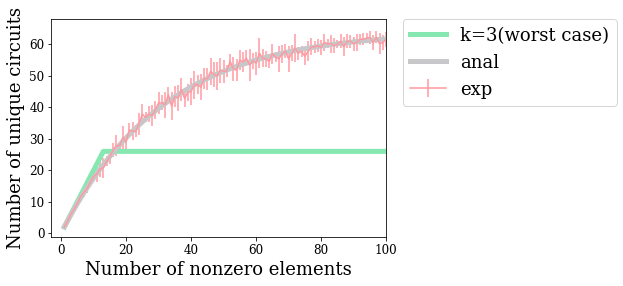

In [26]:
nb_qubits = 5
band_width = 3

psi_0, psi_1, mat_A = get_psi_A(nb_qubits, band_width, trial)
meas = get_all_meas_circs_bits_coefs(psi_0, psi_1, mat_A, 'both', return_circ=False)
nb_circs_max_band = len(meas)

foo = []
for nonzero in range(np.prod(mat_A.shape)):
    if nonzero*2<=nb_circs_max_band:
        foo += [[nonzero,nonzero*2]]
    else:
        foo += [[nonzero,nb_circs_max_band]]
foo = np.array(foo)
plt.plot(foo[1:,0],foo[1:,1],label='k='+str(band_width)+'(worst case)', c=colors[2], linewidth=5)

plt.errorbar(range(1,len(nb_circs_list)+1), nb_circs_list.mean(-1), yerr=nb_circs_list.std(-1), label='exp', color='#FF99A0')
plt.plot(range(1,len(exp_list)+1), np.array(exp_list)*2, label='anal', color=colors[1], linewidth=5)
plt.xlim(-3,100)
plt.xlabel('Number of nonzero elements')
plt.ylabel('Number of unique circuits')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('band-random.pdf')
plt.savefig('band-random.eps')

In [27]:
exp_list[51]*2

52.24005711826345

In [28]:
nb_circs_max_band

26